In [1]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


# Load the Original KDD Cup Data

In order to run this notebook, download and unzip data files from: https://kdd.ics.uci.edu/databases/kddcup98/kddcup98.html

- cup98LRN.txt
- cup98VAL.txt
- valtargt.txt

You need to place these files in the "Data" subfolder.

When working with large dataset, it's good to keep an eye on how much memory we have used.

In [2]:
import os
import psutil

def log_memory_usage():
    pid = os.getpid()
    process = psutil.Process(pid)
    info = process.memory_info()
    print('Process has used {:,d} bytes of memory'.format(info.rss))

print("Before loading data")
log_memory_usage()

Before loading data
Process has used 111,214,592 bytes of memory


In [3]:
trn = pd.read_csv('Data/cup98LRN.txt', low_memory=False)

In [4]:
val = pd.read_csv('Data/cup98VAL.txt', low_memory=False)

In [5]:
val_target = pd.read_csv('Data/valtargt.txt', low_memory=False)

In [6]:
print("After loading data")
log_memory_usage()

After loading data
Process has used 860,958,720 bytes of memory


The dataset used about 750MB of memory. You should be able to run this analysis without much difficulty on a laptop computer.

## Data Exploration

We take a first look at the dataset.

Definition of the data fields can be found here: https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98dic.txt

Tip: save a copy of the what_is function. You may use it for other data analysis tasks.

In [7]:
def what_is(df):
    """Show summary stats of a data frame"""
    ret = []
    for col, dtype in zip(df.columns, df.dtypes):
        if np.issubdtype(dtype, np.number):
            col_values = df[col]
            val_max = col_values.max()
            val_min = col_values.min()
            val_mean = col_values.mean()
            val_median = col_values.median()
            unique_count = len(col_values.unique())
            na_count = np.isnan(col_values).sum()
            non_na_count = len(df) - na_count
        elif np.issubdtype(dtype, np.object):
            col_values = df[col].fillna('')
            val_max = col_values.max()
            val_min = col_values.min()
            val_mean = ''
            val_median = ''
            unique_count = len(col_values.unique())
            na_count = (col_values == '').sum()
            non_na_count = len(df) - na_count
        else:
            val_max = None
            val_min = None
            val_mean = None
            val_median = None
            unique_count = None
            na_count = None
            non_na_count = None
        row = (col, dtype, na_count, non_na_count, unique_count, val_min, val_max, val_median, val_mean)
        ret.append(row)
    summary = pd.DataFrame(ret, columns=['column', 'dtype', 'na_count', 'non_na_count', 'unique_count',
                                         'val_min', 'val_max', 'val_median', 'val_mean'])
    return summary

def print_full(df, max_rows=1000, max_columns=1000, width=1000):
    """Print a data frame in full"""
    with pd.option_context('display.max_rows', max_rows,
                           'display.max_columns', max_columns,
                           'display.width', width):
        display(df)

summary = what_is(trn)
summary.pipe(print_full)

,column,dtype,na_count,non_na_count,unique_count,val_min,val_max,val_median,val_mean
0,ODATEDW,int64,0,95412,54,8306,9701,9201,9141.36
1,OSOURCE,object,0,95412,896,,ZOY,,
2,TCODE,int64,0,95412,55,0,72002,1,54.2231
3,STATE,object,0,95412,57,AA,WY,,
4,ZIP,object,0,95412,19938,00801,99950,,
5,MAILCODE,object,0,95412,2,,B,,
6,PVASTATE,object,0,95412,3,,P,,
7,DOB,int64,0,95412,947,0,9710,2610,2723.6
8,NOEXCH,object,0,95412,4,,X,,
9,RECINHSE,object,0,95412,2,,X,,


Now let's look at the validation data.

In [8]:
# I commented out this line to save some screen space
#what_is(val).pipe(print_full)

In [9]:
print(trn.shape)
print(val.shape)
set(trn.columns).difference(val.columns)

(95412, 481)
(96367, 479)


{'TARGET_B', 'TARGET_D'}

Note that the validation data frame is missing two columns (compared to the training data):

- TARGET_B
- TARGET_D

They can be found in the val_target data frame, which is read from a separate file (valtargt.txt), that contains 3 columns:

- CONTROLN: Control number (unique record identifier)
- TARGET_B: Target Variable / Binary Indicator for Response to the 97NK Mailing
- TARGET_D: Target Variable / Donation Amount (in $) associated with the Response to the 97NK Mailing

In [10]:
what_is(val_target).pipe(print_full)

,column,dtype,na_count,non_na_count,unique_count,val_min,val_max,val_median,val_mean
0,CONTROLN,int64,0,96367,96367,3.0,191776.0,96125.0,96000.714871
1,TARGET_B,int64,0,96367,2,0.0,1.0,0.0,0.050567
2,TARGET_D,float64,0,96367,74,0.0,500.0,0.0,0.789582


According to "valtargt.readme.txt":

    The field CONTROLN will be used as the match key to merge these
    3 fields into the original validation data set (file name:
    cup98VAL.txt)
    
Let's merge val_target and val using "CONTROLN"

In [11]:
val = pd.merge(val, val_target, on='CONTROLN')

## Examing the Features and Targets to Be Used

Here is a summary of the features and targets that we will use in our demo code.

Note that columns starting with "RAMNT_" are previous year donation amounts.

In [12]:
amount_cols = [col for col in trn.columns if col.startswith('RAMNT_')]
other_cols_to_use = ['AVGGIFT', 'LASTGIFT', 'NGIFTALL', 'NUMPROM']
target_cols = ['TARGET_B', 'TARGET_D']

print("train data:")
what_is(trn[other_cols_to_use + amount_cols + target_cols]).pipe(print_full)

print()
print("validation data:")
what_is(val[other_cols_to_use + amount_cols + target_cols]).pipe(print_full)

train data:


,column,dtype,na_count,non_na_count,unique_count,val_min,val_max,val_median,val_mean
0,AVGGIFT,float64,0,95412,7713,1.285714,1000.0,11.636364,13.347786
1,LASTGIFT,float64,0,95412,231,0.000000,1000.0,15.000000,17.313127
2,NGIFTALL,int64,0,95412,89,1.000000,237.0,7.000000,9.602031
3,NUMPROM,int64,0,95412,165,4.000000,195.0,47.000000,46.973347
4,RAMNT_3,float64,95170,242,30,2.000000,50.0,10.000000,12.221074
5,RAMNT_4,float64,95131,281,33,1.000000,100.0,10.000000,14.540107
6,RAMNT_5,float64,95403,9,10,4.000000,50.0,12.000000,17.000000
7,RAMNT_6,float64,94636,776,41,1.000000,100.0,12.000000,14.356920
8,RAMNT_7,float64,86517,8895,76,1.000000,250.0,15.000000,15.088435
9,RAMNT_8,float64,73940,21472,109,1.000000,500.0,15.000000,15.673702



validation data:


,column,dtype,na_count,non_na_count,unique_count,val_min,val_max,val_median,val_mean
0,AVGGIFT,float64,0,96367,7735,1.578947,650.00,11.666667,13.351390
1,LASTGIFT,float64,0,96367,238,0.000000,10000.00,15.000000,17.471620
2,NGIFTALL,int64,0,96367,90,1.000000,126.00,7.000000,9.538421
3,NUMPROM,int64,0,96367,162,4.000000,189.00,47.000000,46.962695
4,RAMNT_3,float64,96152,215,32,2.000000,200.00,10.000000,13.713953
5,RAMNT_4,float64,96062,305,29,1.000000,100.00,10.000000,12.759016
6,RAMNT_5,float64,96350,17,9,5.000000,30.00,11.000000,13.058824
7,RAMNT_6,float64,95542,825,39,1.000000,100.00,12.000000,13.988291
8,RAMNT_7,float64,87454,8913,82,1.000000,203.00,14.000000,14.860956
9,RAMNT_8,float64,74541,21826,106,0.320000,3713.31,15.000000,15.862533


# Replicate the 4 Variable Regression Analysis

Here we replicate the 4 variable regression model in class

- avggift: average dollar amount of gifts to date
- lastgift: dollar amount of most recent gift
- ampergift: average amount of gift from included records
- pgift: d['NGIFTALL']/d['NUMPROM']

In [13]:
def featurize(df):
    amount_cols = [col for col in df.columns if col.startswith('RAMNT_')]
    ret = pd.concat([
        df['AVGGIFT'],
        df['LASTGIFT'],
        df['NGIFTALL']/df['NUMPROM'],
        # We generate another feature by averaging all RAMNT_ columns
        df[amount_cols].mean(axis=1, skipna=True).fillna(0),
    ], axis=1)
    ret.columns = ['avggift', 'lastgift', 'pgift', 'ampergift']
    return ret

trn_x = featurize(trn)
val_x = featurize(val)

print("train data summary:")
what_is(trn_x).pipe(print_full)
print()
print("validation data summary:")
what_is(val_x).pipe(print_full)

train data summary:


,column,dtype,na_count,non_na_count,unique_count,val_min,val_max,val_median,val_mean
0,avggift,float64,0,95412,7713,1.285714,1000.000000,11.636364,13.347786
1,lastgift,float64,0,95412,231,0.000000,1000.000000,15.000000,17.313127
2,pgift,float64,0,95412,2277,0.025000,1.768657,0.157895,0.179621
3,ampergift,float64,0,95412,1469,0.000000,1000.000000,15.000000,15.993879



validation data summary:


,column,dtype,na_count,non_na_count,unique_count,val_min,val_max,val_median,val_mean
0,avggift,float64,0,96367,7735,1.578947,650.00,11.666667,13.351390
1,lastgift,float64,0,96367,238,0.000000,10000.00,15.000000,17.471620
2,pgift,float64,0,96367,2290,0.025000,1.50,0.156863,0.178764
3,ampergift,float64,0,96367,1418,0.000000,3713.31,15.000000,16.092854


Let's look at the first 5 rows of the feature data frame. They match what we had in the previous demo.

In [14]:
trn_x.head()

,avggift,lastgift,pgift,ampergift
0,7.741935,10.0,0.418919,10.428571
1,15.666667,25.0,0.093750,18.500000
2,7.481481,5.0,0.428571,8.285714
3,6.812500,10.0,0.242424,9.285714
4,6.864865,15.0,0.327434,12.500000


In [15]:
val_x.head()

,avggift,lastgift,pgift,ampergift
0,15.333333,15.0,0.142857,26.5
1,15.000000,20.0,0.095238,15.0
2,24.444444,25.0,0.147541,0.0
3,13.666667,19.0,0.093750,18.0
4,5.750000,10.0,0.170213,6.6


## Response Rate Model

We fit a logistic regression model on the response rate.

On training data
AUC = 0.5925


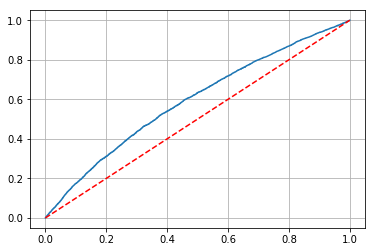

On testing data
AUC = 0.5934


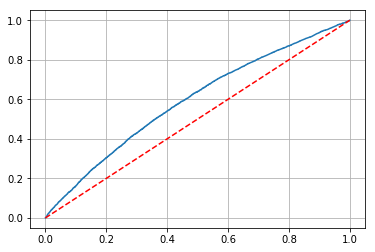

In [16]:
from sklearn.linear_model import LogisticRegression

# TARGET_B represents whether someone has donated or not
trn_y = trn['TARGET_B']
val_y = val['TARGET_B']

m = LogisticRegression()
m.fit(trn_x, trn_y)

def plot_auc(target, pred):
    fpr, tpr, _ = roc_curve(y_true=target, y_score=pred)
    plot(fpr, tpr)
    plot([0, 1], [0, 1], 'r--')
    grid()
    print('AUC = {:.4f}'.format(auc(fpr, tpr)))
    show()

print("On training data")
pred = m.predict_proba(trn_x)[:,1]
target = trn_y
plot_auc(target=target, pred=pred)

print("On testing data")
pred = m.predict_proba(val_x)[:,1]
target = val_y
plot_auc(target=target, pred=pred)

# save the prediction for later use
pred_response_prob = m.predict_proba(val_x)[:,1]

## Donation Amount Model

Next, we fit a linear regression model on the donation amount:

in training data, found 4843 samples with positive donation amount
in validation data, found 4873 samples with positive donation amount
On training data
R-squared: 0.548


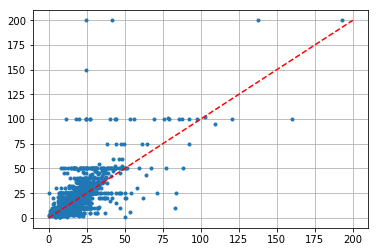

On testing data
R-squared: 0.668


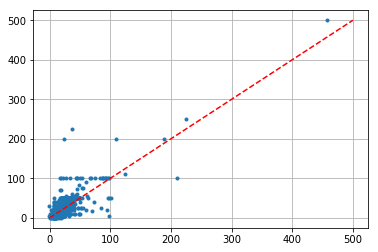

In [17]:
from sklearn.linear_model import LinearRegression

idx = trn['TARGET_D'] > 0
print("in training data, found {} samples with positive donation amount".format(sum(idx)))
trn_x_amount = trn_x.loc[idx]
trn_y_amount = trn.loc[idx, 'TARGET_D']

idx = val['TARGET_D'] > 0
print("in validation data, found {} samples with positive donation amount".format(sum(idx)))
val_x_amount = val_x.loc[idx]
val_y_amount = val.loc[idx, 'TARGET_D']

m = LinearRegression()
m.fit(trn_x_amount, trn_y_amount)

def plot_rsquared(target, pred):
    print('R-squared: {:.3f}'.format(r2_score(y_true=target, y_pred=pred)))
    plot(pred, target, '.')
    grid()
    y_max = max(pred.max(), target.max())
    plot([0, y_max], [0, y_max], 'r--')
    show()

print("On training data")
pred = m.predict(trn_x_amount)
target = trn_y_amount
plot_rsquared(target=target, pred=pred)

print("On testing data")
pred = m.predict(val_x_amount)
target = val_y_amount
plot_rsquared(target=target, pred=pred)

# save the amount prediction for later use
pred_amount = m.predict(val_x)

## Donation Amount Prediction

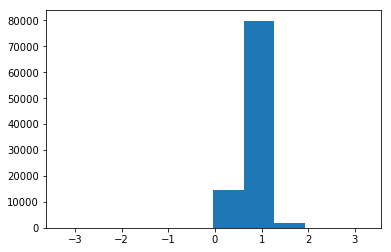

In [18]:
expected_donation = pred_amount * pred_response_prob
hist(expected_donation)
show()

In [19]:
actual_donation = val['TARGET_D']

In [20]:
cost_per_mail = 0.68
idx = expected_donation > cost_per_mail
print('Total net donation: {:.2f}'.format(np.sum(actual_donation[idx] - cost_per_mail)))

Total net donation: 11525.29


In [21]:
print('Total net donation (mail every one): {:.2f}'.format(np.sum(actual_donation - cost_per_mail)))

Total net donation (mail every one): 10560.08


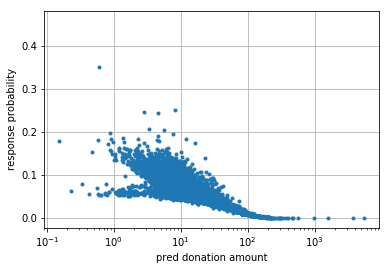

In [22]:
plot(pred_amount, pred_response_prob, '.')
xlabel('pred donation amount')
ylabel('response probability')
xscale('log')
grid()